### Challenge Lab

**Instructions**: Build a model using a Built-in Algorithm that performs better than the model we have trained in Lab 008. Use the Automated Model Tuning capability of SageMaker to help you find the best model.

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.set_printoptions(suppress=True, precision=2)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [53]:
df = pd.read_csv("files/003.csv")
df.head()

,target,a,b,c,d,e,f,g,h
0,151400,2,2,3,7,37,0,3,0
1,286000,4,4,6,16,64,0,6,0
2,172200,2,2,4,24,16,2,3,0
3,141400,4,4,4,0,32,1,4,0
4,100800,3,3,4,8,8,0,4,0


In [54]:
from sklearn.model_selection import train_test_split

# X = df.drop('target', axis=1)
X = df.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X.values, df['target'].values, test_size=0.20, random_state=0)

In [87]:
X_train

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 10,  10,  10, ...,   0,  10,   0],
       [ 24,  24,  24, ...,   6,  24,   0],
       ...,
       [ 50,  50,  10, ...,   0,   0,   0],
       [ 60,  20,  10, ...,   0,   0,  60],
       [  0,   0,   0, ...,   0,   0, 120]])

In [56]:
y_train

array([   9600,  634000,  848400,  612800,  456000,  712800,   28800,
        960000,   84800,  148800,  720000,  480000, 1570800, 1047200,
        749600,  470400,  169600,  302800,  344400, 2580000,   95200,
       3084000,  433600,  630800, 1300800,  919200,  201600,  143000,
       2280000,  286000,   92800,  393000,   46400,  448000,  216800,
        856000,  823200, 1716000, 1646400, 1128800,  313600,  100800,
        480000,  424200,  666000,  749600,  356400,  224000, 2736000,
       2508000,  254400,  572000,  868800, 1028000,  561600, 1720000,
        219600,  141400,  429000,  380000,  572000,  146400, 1268000,
        516600,  680000, 1225600,  606000,  548800,  418000, 1300800,
        168000, 1208000,  190400, 1902000, 1268000,  172200,  313600,
        860000,  888000,   84000,  564400, 1208000,  454200,  912000,
        120000,  786000, 1360000,  842400,  302400,  786000, 1212000,
        109800, 2568000,  548800,  240000, 3624000,  282800,  680000,
        480000,  240

In [57]:
import io
import sagemaker
import sagemaker.amazon.common as smac

sesh = sagemaker.Session()
bucket = sesh.default_bucket()

# convert the training data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms

# init memory buffer in RAM where data will be written
buf = io.BytesIO()

# write train data (numpy array) into a dense tensor 
# smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
smac.write_numpy_to_dense_tensor(buf, X_train.reshape(-1, 8).astype("float32"), y_train.astype("float32"))

# sets the file's current position at the offset (0)
# i.e. set the reference point to the beginning of the memory buffer
buf.seek(0)

0

In [58]:
import os
import boto3

# upload training data to s3
key = "009-train-data"
prefix = "sagemaker/009"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"

print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://sagemaker-us-east-1-305262579855/sagemaker/009/train/009-train-data


In [59]:
# convert the validation data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms 

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_val.astype("float32").reshape(-1, 8), y_val.astype("float32"))
buf.seek(0)

0

In [60]:
# upload validation data to s3

key = "009-valid-data"
prefix = "sagemaker/009"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "valid", key)).upload_fileobj(buf)
s3_valid_data = f"s3://{bucket}/{prefix}/valid/{key}"

print(f"uploaded validation data location: {s3_train_data}")

uploaded validation data location: s3://sagemaker-us-east-1-305262579855/sagemaker/009/train/009-train-data


In [61]:
import boto3
import sagemaker
from sagemaker import tuner
from sagemaker import get_execution_role

role = get_execution_role()
sesh = sagemaker.Session()
bucket = sesh.default_bucket()
region = boto3.Session().region_name    
client = boto3.Session().client('sagemaker')

In [62]:
from sagemaker.image_uris import retrieve

container = retrieve('linear-learner', region, version="1")
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [16]:
!pip install 'sagemaker[local]' --upgrade

In [63]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


In [64]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sesh
)

In [65]:
estimator.set_hyperparameters(
    predictor_type='regressor',
    normalize_data=True,
    optimizer="adam",
)

In [66]:
hyperparameter_ranges = {
    'learning_rate': tuner.ContinuousParameter(1e-5, 1),
    'mini_batch_size': tuner.IntegerParameter(2, 10),
    'l1': tuner.ContinuousParameter(1e-7, 1),
    'use_bias': tuner.CategoricalParameter([True, False]),
    'wd': tuner.ContinuousParameter(1e-7, 1)
}

In [67]:
objective_metric_name = 'validation:objective_loss'

In [68]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=12,
    max_parallel_jobs=3
)

In [69]:
hyperparameter_tuner.fit(
    {'train': s3_train_data, 'validation': s3_valid_data},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

'InProgress'

In [70]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 6, 5, 8, 30, 40, 617000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/linear-learner-210605-0830',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:objective_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [{'Name': 'use_bias',
                                                                                       'Values': ['True',
                                                                                                  'False']}],
                                                       'ContinuousParameterRanges': [{'MaxValue': '1',
                                                                                      'MinValue': '1e-05',
                                             

In [71]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7fc664be11d0>,
 'objective_metric_name': 'validation:objective_loss',
 '_hyperparameter_ranges': {'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7fc6627cf390>,
  'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7fc6627cf940>,
  'l1': <sagemaker.parameter.ContinuousParameter at 0x7fc6627cf400>,
  'use_bias': <sagemaker.parameter.CategoricalParameter at 0x7fc6627cfeb8>,
  'wd': <sagemaker.parameter.ContinuousParameter at 0x7fc6627cf518>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 12,
 'max_parallel_jobs': 3,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name': 'linear-learner-210605-0830',
 'latest_tuning_job': <sagemaker.tuner._TuningJob at 0x7fc664bd2080>,
 'warm_start_

In [72]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'linear-learner-210605-0830'

In [73]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [75]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

latest_df().sort_values('FinalObjectiveValue', ascending=True)

,l1,learning_rate,mini_batch_size,use_bias,wd,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.0000117427,0.0492325764,9.0000000000,True,0.0000033638,linear-learner-210605-0830-012-c346db1e,Completed,11993322496.0000000000,2021-06-05 08:47:01+00:00,2021-06-05 08:48:17+00:00,76.0000000000
5,0.0000001248,0.0020420037,8.0000000000,False,0.0000002638,linear-learner-210605-0830-007-9c7c3953,Completed,12263449600.0000000000,2021-06-05 08:42:49+00:00,2021-06-05 08:44:03+00:00,74.0000000000
4,0.0000001517,0.9189876876,2.0000000000,False,0.0958499963,linear-learner-210605-0830-008-f645126b,Completed,18790369280.0000000000,2021-06-05 08:42:47+00:00,2021-06-05 08:43:59+00:00,72.0000000000
8,0.0000378051,0.4094538476,2.0000000000,False,0.0000002363,linear-learner-210605-0830-004-89302985,Completed,20112752640.0000000000,2021-06-05 08:38:23+00:00,2021-06-05 08:39:30+00:00,67.0000000000
7,0.0000004888,0.5141406114,4.0000000000,False,0.0042699848,linear-learner-210605-0830-005-66bb556d,Completed,27814440960.0000000000,2021-06-05 08:38:13+00:00,2021-06-05 08:39:33+00:00,80.0000000000
6,0.0000006747,0.5141406114,4.0000000000,False,0.0030933305,linear-learner-210605-0830-006-5e669c66,Completed,29801060352.0000000000,2021-06-05 08:38:08+00:00,2021-06-05 08:39:29+00:00,81.0000000000
11,0.0001943719,0.2732908696,6.0000000000,False,0.0015788296,linear-learner-210605-0830-001-eedde26f,Completed,104948572160.0000000000,2021-06-05 08:33:26+00:00,2021-06-05 08:34:42+00:00,76.0000000000
9,0.1196055414,0.0004430244,2.0000000000,True,0.0000076043,linear-learner-210605-0830-003-216ff8ab,Completed,278091202560.0000000000,2021-06-05 08:33:32+00:00,2021-06-05 08:35:21+00:00,109.0000000000
10,0.2011335612,0.0004450943,7.0000000000,True,0.0005756771,linear-learner-210605-0830-002-07821602,Completed,369924734976.0000000000,2021-06-05 08:33:37+00:00,2021-06-05 08:35:20+00:00,103.0000000000
3,0.0000003478,0.4511481848,5.0000000000,False,0.0000001560,linear-learner-210605-0830-009-e883b035,Completed,480758988800.0000000000,2021-06-05 08:43:04+00:00,2021-06-05 08:44:19+00:00,75.0000000000


In [76]:
import sagemaker

sesh = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sesh
)

linear.set_hyperparameters(
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=9,
    l1=0.0000117427,
    learning_rate=0.0492325764,
    use_bias=True,
    wd=0.0000033638
)

In [77]:
linear.fit(inputs={"train": s3_train_data, "validation": s3_valid_data})

2021-06-05 08:51:58 Starting - Starting the training job...
2021-06-05 08:52:22 Starting - Launching requested ML instancesProfilerReport-1622883117: InProgress
......
2021-06-05 08:53:23 Starting - Preparing the instances for training.........
2021-06-05 08:54:47 Downloading - Downloading input data...
2021-06-05 08:55:23 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/05/2021 08:55:35 INFO 139953232955200] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 

In [78]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
print(f"\ncreated endpoint: {linear_predictor.endpoint_name}")

---------------------!
created endpoint: linear-learner-2021-06-05-08-56-11-696


In [80]:
from sagemaker.serializers import CSVSerializer

linear_predictor.serializer = CSVSerializer()
payload = df.drop(['target'], axis=1)
result = linear_predictor.predict(payload.values)

In [81]:
import json

res = json.loads(result.decode())
res['predictions'][0]

{'score': 148868.5625}

In [84]:
y_pred_len = len(res['predictions'])
y_pred_len

270

In [82]:
y_pred_len = len(res['predictions'])
y_pred_scores = []

for i in range(y_pred_len):
    y_pred_scores.append(res['predictions'][i].get('score'))

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  270 non-null    int64
 1   a       270 non-null    int64
 2   b       270 non-null    int64
 3   c       270 non-null    int64
 4   d       270 non-null    int64
 5   e       270 non-null    int64
 6   f       270 non-null    int64
 7   g       270 non-null    int64
 8   h       270 non-null    int64
dtypes: int64(9)
memory usage: 19.1 KB


In [90]:
# init output DF
output_df = pd.DataFrame()

# populate DF
output_df['Actual'] = df['target'].values
output_df['Predicted'] = y_pred_scores

output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Actual     270 non-null    int64  
 1   Predicted  270 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '\nHyperparameter-tuned Linear Learner Model\nActual vs. Predicted values\n')

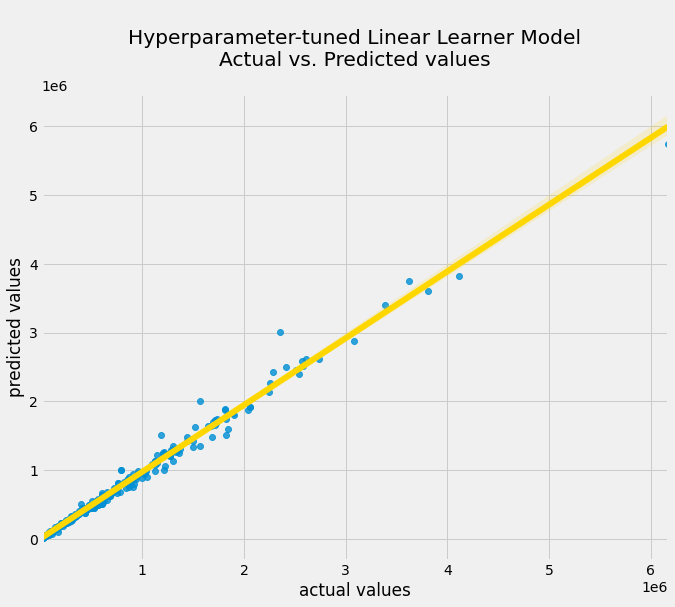

In [91]:
import seaborn as sns
import matplotlib.pylab as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))

sns.regplot(output_df['Actual'], output_df['Predicted'], line_kws={'color': 'gold'})

plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("\nHyperparameter-tuned Linear Learner Model\nActual vs. Predicted values\n")

In [95]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

# helper function for evaluating a model
def evaluate(labels, predictions):
    # get rmse values and r^2 scores 
    rmse = np.sqrt(MSE(labels, predictions))
    
    r2 = r2_score(labels, predictions)
    
    return rmse, r2

# get rmse values and r^2 scores using the helper function
lr_rmse, lr_r2 = evaluate(output_df['Actual'], output_df['Predicted'])

print(f'\nRMSE = {lr_rmse}')
print(f'R^2 Score = {lr_r2 * 100}\n')


RMSE = 88923.13144556922
R^2 Score = 98.74362274799591



In [96]:
linear_predictor.delete_endpoint()
print(f"deleted {linear_predictor.endpoint_name} successfully!")

deleted linear-learner-2021-06-05-08-56-11-696 successfully!
